In [ ]:
# Install latest pre-release version of bigdl-chronos 
# Installing bigdl-chronos from pip will automatically install pyspark, bigdl, and their dependencies.
# !pip install --pre --upgrade bigdl-chronos[all]
!pip install bigdl-chronos[all]==2.0.0
!pip uninstall -y torchtext # uninstall torchtext to avoid version conflict
!pip install torchmetrics==0.7.3
exit() # restart the runtime to refresh installed pkg

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# run

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("/content/drive/MyDrive/Khoá luận tốt nghiệp/Dataset/final_data_6.csv")
df['datetime'] = df['datetime'].astype('datetime64')
df

#------------>>> IMPORT NECESARY LIBRARIES AND MODULES
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import bigdl.orca.automl.hp as hp
from bigdl.chronos.autots import AutoTSEstimator
import torch
from torch import nn

#------------>>> RECOMMENDED TO SET IT TO TRUE WHEN RUNNING BIGDL-CHRONOS IN JUPYTER NOTEBOOK 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

init_orca_context(cluster_mode="local", cores=4, init_ray_on_spark=True) # run in local mode
#init_orca_context(cluster_mode="k8s", master="k8s://https://<k8s-apiserver-host>:<k8s-apiserver-port>", container_image="intelanalytics/bigdl-k8s:latest", num_nodes=2, cores=2, init_ray_on_spark=True, conda_name='Anaconda3-5.1.0-Linux-x86_64') # run on K8s cluster
#init_orca_context(cluster_mode="yarn-client", num_nodes=2, cores=2, init_ray_on_spark=True) # run on Hadoop YARN cluster

#------------>>> CREATE LIST FEATURE
#time_ft = ['weekend']
location_ft = ['lat', 'long']
link_ft = ['20223', 'GL1', '1255', '1405', '1404', '1403', 'GL2', '1271','1253', '1401', 'GL3', '1283', '1258', '1256']
weather_ft = ['rhum', 'sun', 'vis']

# ft = [location_ft, link_ft, weather_ft,
#       location_ft+link_ft, location_ft+weather_ft, link_ft+weather_ft,
#       location_ft+link_ft+weather_ft]

ft = [location_ft+link_ft+weather_ft, location_ft+link_ft, link_ft+weather_ft, link_ft, location_ft, weather_ft, location_ft+weather_ft]

# ft = [
#       time_ft, location_ft, link_ft, weather_ft,
#       time_ft+location_ft, time_ft+link_ft,  time_ft+weather_ft, location_ft+link_ft, location_ft+weather_ft, link_ft+weather_ft,
#       time_ft+location_ft+link_ft, time_ft+location_ft+weather_ft, time_ft+link_ft+weather_ft, location_ft+link_ft+weather_ft,
#       time_ft+location_ft+link_ft+weather_ft
#     ]

#------------>>> COMPONENTS TO MAKE A EVALUATE TABLE
dict_scores={}
# ft_text = [
#       'None', 'time_ft', 'location_ft', 'link_ft', 'weather_ft',
#       'time_ft + location_ft', 'time_ft + link_ft',  'time_ft + weather_ft', 'location_ft + link_ft', 'location_ft + weather_ft', 'link_ft + weather_ft',
#       'time_ft + location_ft + link_ft', 'time_ft + location_ft + weather_ft', 'time_ft + link_ft + weather_ft', 'location_ft + link_ft + weather_ft',
#       'time_ft + location_ft + link_ft + weather_ft']
# ft_text = ['None', 'location_ft', 'link_ft', 'weather_ft',
#            'location_ft + link_ft', 'location_ft + weather_ft', 'link_ft + weather_ft',
#            'location_ft + link_ft + weather_ft']
ft_text = ['None', 'location_ft + link_ft + weather_ft', 'location_ft + link_ft', 'link_ft + weather_ft', 'link_ft', 'location_ft', 'weather_ft', 'location_ft + weather_ft']
list_rmse=[]
list_mae=[]
# list_smape=[]
# list_r2=[]
# list_mape=[]
list_best_config=[]

class GRUNet(nn.Module):
    def __init__(self, input_dim, layer_num, hidden_dim, dropout, output_dim):
        super(GRUNet, self).__init__()
        self.layer_num = layer_num
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(input_dim, hidden_dim, layer_num, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_seq):
        h0 = torch.randn(self.layer_num, input_seq.size(0), self.hidden_dim)
        gru_out, _ = self.gru(input_seq, h0)
        out = self.fc(gru_out[:, -1, :])
        out = out.view(out.shape[0], 1, out.shape[-1])
        return out

# def model_creator(config):
#     return LSTMNet(input_dim=1,
#                   layer_num=config['layer_num'],
#                   hidden_dim=config['hidden_dim'],
#                   dropout=config['dropout'],
#                   output_dim=1)
    


#------------>>> LOOP FOR FEATURES
for i in range(8):
  if (i == 0):
    tsdata_train, tsdata_val, tsdata_test = TSDataset.from_pandas(df, dt_col="datetime", id_col="id", target_col="value", with_split=True, val_ratio=0.1, test_ratio=0.1)
  else:
    tsdata_train, tsdata_val, tsdata_test = TSDataset.from_pandas(df, dt_col="datetime", id_col="id", target_col="value", extra_feature_col=ft[i-1] , with_split=True, val_ratio=0.1, test_ratio=0.1)

  minmax_scaler = MinMaxScaler()

  for tsdata in [tsdata_train, tsdata_val, tsdata_test]:
    tsdata.scale(minmax_scaler, fit=(tsdata is tsdata_train)).roll(lookback=50, horizon=1)

  X_train, y_train = tsdata_train.to_numpy()
  X_val, y_val = tsdata_val.to_numpy()
  X_test, y_test = tsdata_test.to_numpy()
  X_train.shape, y_train.shape, X_test.shape, y_test.shape

 

  feature_dim = X_train.shape[-1]


  def model_creator(config):
    return GRUNet(input_dim=feature_dim,
                  layer_num=config['layer_num'],
                  hidden_dim=config['hidden_dim'],
                  dropout=config['dropout'],
                  output_dim=1)
  
  # >> CONFIGURE SEARCH_SPACE <<
  # search_space = {"hidden_dim": 32, # it takes ~20 mins
  #               "layer_num": 1,
  #               "lr": 0.01,
  #               "dropout": 0.1}

  # search_space = {"hidden_dim": hp.grid_search([16, 32]), #CRASH RUNTIME
  #                 "layer_num": hp.grid_search([1, 2]),
  #                 "lr": hp.loguniform(0.0005, 0.01),
  #                 "dropout": hp.uniform(0, 0.2)}

  # search_space1 = {"hidden_dim": hp.grid_search([16, 32]), # it takes 108.55 mins
  #                 "layer_num": hp.grid_search([1, 2]),
  #                 "lr": hp.loguniform(0.005, 0.01),
  #                 "dropout": hp.uniform(0.1, 0.2)}

  # search_space2 = {"hidden_dim": hp.grid_search([16, 32]), # it takes 108.03 mins
  #                 "layer_num": hp.grid_search([1, 2]),
  #                 "lr": 0.01,
  #                 "dropout": 0.2}

  # search_space3 = {"hidden_dim": hp.grid_search([16, 32]), # it takes 38.28 mins
  #                 "layer_num": hp.randint(1, 2),
  #                 "lr": 0.01,
  #                 "dropout": 0.2}   

  # search_space4 = {"hidden_dim": hp.grid_search([16, 32]), # it takes 68.15 mins
  #                 "layer_num": 2,
  #                 "lr": 0.01,
  #                 "dropout": 0.2}              

  # search_space5 = {"hidden_dim": hp.grid_search([16, 32]), # it takes 40 mins
  #                 "layer_num": hp.randint(1, 2),
  #                 "lr": hp.loguniform(0.005, 0.01),
  #                 "dropout": hp.uniform(0.1, 0.2)}  

  # search_space6 = {"hidden_dim": 32, # it takes 13.76 mins
  #                 "layer_num": 1,
  #                 "lr": hp.loguniform(0.005, 0.01),
  #                 "dropout": hp.uniform(0.1, 0.2)}

  search_space7 = {"hidden_dim": 32,
                  "layer_num": 2,
                  "lr": hp.loguniform(0.005, 0.01),
                  "dropout": hp.uniform(0.1, 0.2)}

  search_space8 = {"hidden_dim": 32,
                  "layer_num": 2,
                  "lr": 0.01,
                  "dropout": 0.2}
  

  # >> CREATE AN AutoTSEstimator <<
  auto_estimator = AutoTSEstimator(model=model_creator,
                               search_space=search_space8, # a default hyper parameter search space
                                 past_seq_len=50, future_seq_len=1, # hp sampling function of past_seq_len for auto-tuning
                                 selected_features="all")
  
  # >> FIT WITH AutoTSEstimator FOR A RETURNED TSPipeline <<
  ts_pipeline = auto_estimator.fit(data=tsdata_train, # train dataset
                                   validation_data=tsdata_val, # validation dataset
                                   batch_size=128, epochs=3) # number of epochs to train in each trial

  # >> PREDICT WITH THE BEST TRIAL <<
  y_pred = ts_pipeline.predict(tsdata_test)

  # >> EVALUATE THE RESULT PIPELINE <<
  # rmse, mape = ts_pipeline.evaluate(tsdata_test, metrics=["rmse", "mape"])
  rmse, mae = ts_pipeline.evaluate(tsdata_test, metrics=["rmse", "mae"])
  #mae, smape, r2, rmse, mape = ts_pipeline.evaluate(tsdata_test, metrics=["mae", "smape", "r2", "rmse", "mape"])
  # print("Evaluate: the mean absolute error is", mae)
  # print("Evaluate: the smape value is", smape)
  # print("Evaluate: the r2 value is", r2)
  # print("Evaluate: the rmse value is", rmse)
  # print("Evaluate: the mape value is", mape)
  list_rmse.append(rmse)
  list_mae.append(mae)
  # list_smape.append(smape)
  # list_r2.append(r2)
  # list_mape.append(mape)

  # >> GET BEST CONFIG <<
  best_config = auto_estimator.get_best_config()
  list_best_config.append(best_config)

  print(ft_text[i])
  print("rmse: " + str(rmse) + "\nmae: " + str(mae))
  print("\n") 

  if len(list_rmse) >= 2:
    if list_rmse[1] > min(list_rmse):
      exit()
      break

#------------>>> CREATE EVALUATE TABLE
dict_scores['Extra_feature_col'] = ft_text
dict_scores['RMSE Score'] = list_rmse
dict_scores['MAE Score'] = list_mae
# dict_scores['SMAPE Score'] = list_smape
# dict_scores['R2 Score'] = list_r2
# dict_scores['MAPE Score'] = list_mape
dict_scores['Best config'] = list_best_config
evaluate_table = pd.DataFrame.from_dict(dict_scores)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Initializing orca context
Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-2.0.0-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-2.0.0-jar-with-dependencies.jar pyspark-shell 
[main] WARN  org.apache.hadoop.util.NativeCodeLoader  - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2022-04-28 15:36:44,058 Thread-3 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-04-28 15:36:44,063 Thread-3 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-04-28 15:36:44,065 Thread-3 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-04-28 15:36:44,067 Thread-3 WARN The bufferSize is set to 4000 but bufferedIo is false: false
22-04-28 15:36:44 [Thread-3] INFO  Engine$:121 - Auto detect executor number and executor cores number
22-04-28 15:36:44 [Thread-3] INFO  Engine$:123 - Executor number is 1 and executor cores number is 4



User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_ITT_PREPARE_DELAY=0
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
  

22-04-28 15:36:45 [Thread-3] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 16
[Thread-3] WARN  org.apache.spark.SparkContext  - Using an existing SparkContext; some configuration may not take effect.
22-04-28 15:36:45 [Thread-3] INFO  Engine$:446 - Find existing spark context. Checking the spark conf...
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.Sample
Successfully got a SparkContext
BigDLBasePickler registering: bigdl.dllib.utils.common  Sample
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.EvaluatedResult
BigDLBasePickler registering: bigdl.dllib.utils.common  EvaluatedResult
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.JTensor
BigDLBasePickler registering: bigdl.dllib.utils.common  JTensor
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.JActivity
BigDLBasePickler registering: bigdl.dllib.utils.common  JActivity


2022-04-28 15:36:48,365	INFO services.py:1340 -- View the Ray dashboard at http://172.28.0.2:8265


{'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': '172.28.0.2:6379', 'object_store_address': '/tmp/ray/session_2022-04-28_15-36-45_237598_2205/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-04-28_15-36-45_237598_2205/sockets/raylet', 'webui_url': '172.28.0.2:8265', 'session_dir': '/tmp/ray/session_2022-04-28_15-36-45_237598_2205', 'metrics_export_port': 56365, 'node_id': '5ec9e054bd0598493b789edf3b78f15f286915c79fea628e0ff051a5'}


2022-04-28 15:36:52,313	WARNING function_runner.py:562 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2022-04-28 15:36:52,491	WARNING tune.py:570 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


Trial name,status,loc
train_func_06bf0_00000,PENDING,


(ImplicitFunc pid=2459) /usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
(ImplicitFunc pid=2459)   import pandas.util.testing as tm


Trial name,status,loc
train_func_06bf0_00000,RUNNING,172.28.0.2:2459


Trial name,status,loc
train_func_06bf0_00000,RUNNING,172.28.0.2:2459


Trial name,status,loc
train_func_06bf0_00000,RUNNING,172.28.0.2:2459


Trial name,status,loc
train_func_06bf0_00000,RUNNING,172.28.0.2:2459


Trial name,status,loc
train_func_06bf0_00000,RUNNING,172.28.0.2:2459


Trial name,status,loc
train_func_06bf0_00000,RUNNING,172.28.0.2:2459


Trial name,status,loc
train_func_06bf0_00000,RUNNING,172.28.0.2:2459


Trial name,status,loc
train_func_06bf0_00000,RUNNING,172.28.0.2:2459


Trial name,status,loc
train_func_06bf0_00000,RUNNING,172.28.0.2:2459


Trial name,status,loc
train_func_06bf0_00000,RUNNING,172.28.0.2:2459


Trial name,status,loc
train_func_06bf0_00000,RUNNING,172.28.0.2:2459


Trial name,status,loc
train_func_06bf0_00000,RUNNING,172.28.0.2:2459


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,1,62.0713,0.00126716,0.00126716


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,1,62.0713,0.00126716,0.00126716


2022-04-28 15:38:06,467	WARNING worker.py:1245 -- (ip=172.28.0.2) The agent on node 7c05957016bf failed to be restarted 5 times. There are 3 possible problems if you see this error.
  1. The dashboard might not display correct information on this node.
  2. Metrics on this node won't be reported.
  3. runtime_env APIs won't work.
Check out the `dashboard_agent.log` to see the detailed failure messages.


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,1,62.0713,0.00126716,0.00126716


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,1,62.0713,0.00126716,0.00126716


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,1,62.0713,0.00126716,0.00126716


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,1,62.0713,0.00126716,0.00126716


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,1,62.0713,0.00126716,0.00126716


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,1,62.0713,0.00126716,0.00126716


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,1,62.0713,0.00126716,0.00126716


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,1,62.0713,0.00126716,0.00126716


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,1,62.0713,0.00126716,0.00126716


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,1,62.0713,0.00126716,0.00126716


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,2,120.867,0.00105498,0.00105498


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,2,120.867,0.00105498,0.00105498


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,2,120.867,0.00105498,0.00105498


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,2,120.867,0.00105498,0.00105498


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,2,120.867,0.00105498,0.00105498


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,2,120.867,0.00105498,0.00105498


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,2,120.867,0.00105498,0.00105498


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,2,120.867,0.00105498,0.00105498


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,2,120.867,0.00105498,0.00105498


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,2,120.867,0.00105498,0.00105498


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,RUNNING,172.28.0.2:2459,2,120.867,0.00105498,0.00105498


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_06bf0_00000,TERMINATED,172.28.0.2:2459,3,178.717,0.000951652,0.000951652


2022-04-28 15:39:53,664	INFO tune.py:626 -- Total run time: 181.36 seconds (181.04 seconds for the tuning loop).


None
rmse: 138.79407002699682
mae: 92.70702001808985




2022-04-28 15:40:07,556	WARNING tune.py:570 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


Trial name,status,loc
train_func_7b191_00000,RUNNING,172.28.0.2:2458


(ImplicitFunc pid=2458) /usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
(ImplicitFunc pid=2458)   import pandas.util.testing as tm


Trial name,status,loc
train_func_7b191_00000,RUNNING,172.28.0.2:2458


Trial name,status,loc
train_func_7b191_00000,RUNNING,172.28.0.2:2458


Trial name,status,loc
train_func_7b191_00000,RUNNING,172.28.0.2:2458


Trial name,status,loc
train_func_7b191_00000,RUNNING,172.28.0.2:2458


Trial name,status,loc
train_func_7b191_00000,RUNNING,172.28.0.2:2458


Trial name,status,loc
train_func_7b191_00000,RUNNING,172.28.0.2:2458


Trial name,status,loc
train_func_7b191_00000,RUNNING,172.28.0.2:2458


Trial name,status,loc
train_func_7b191_00000,RUNNING,172.28.0.2:2458


Trial name,status,loc
train_func_7b191_00000,RUNNING,172.28.0.2:2458


Trial name,status,loc
train_func_7b191_00000,RUNNING,172.28.0.2:2458


Trial name,status,loc
train_func_7b191_00000,RUNNING,172.28.0.2:2458


Trial name,status,loc
train_func_7b191_00000,RUNNING,172.28.0.2:2458


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,1,61.9727,0.0013538,0.0013538


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,1,61.9727,0.0013538,0.0013538


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,1,61.9727,0.0013538,0.0013538


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,1,61.9727,0.0013538,0.0013538


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,1,61.9727,0.0013538,0.0013538


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,1,61.9727,0.0013538,0.0013538


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,1,61.9727,0.0013538,0.0013538


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,1,61.9727,0.0013538,0.0013538


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,1,61.9727,0.0013538,0.0013538


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,1,61.9727,0.0013538,0.0013538


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,1,61.9727,0.0013538,0.0013538


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,1,61.9727,0.0013538,0.0013538


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,1,61.9727,0.0013538,0.0013538


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,2,126.226,0.00101705,0.00101705


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,2,126.226,0.00101705,0.00101705


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,2,126.226,0.00101705,0.00101705


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,2,126.226,0.00101705,0.00101705


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,2,126.226,0.00101705,0.00101705


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,2,126.226,0.00101705,0.00101705


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,2,126.226,0.00101705,0.00101705


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,2,126.226,0.00101705,0.00101705


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,2,126.226,0.00101705,0.00101705


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,2,126.226,0.00101705,0.00101705


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,2,126.226,0.00101705,0.00101705


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,RUNNING,172.28.0.2:2458,2,126.226,0.00101705,0.00101705


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_7b191_00000,TERMINATED,172.28.0.2:2458,3,188.778,0.000895161,0.000895161


2022-04-28 15:43:18,360	INFO tune.py:626 -- Total run time: 190.82 seconds (190.68 seconds for the tuning loop).


location_ft + link_ft + weather_ft
rmse: 128.86286191635898
mae: 86.92000863862154




2022-04-28 15:43:29,484	WARNING tune.py:570 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


Trial name,status,loc
train_func_f374f_00000,PENDING,


(ImplicitFunc pid=2745) /usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
(ImplicitFunc pid=2745)   import pandas.util.testing as tm


Trial name,status,loc
train_func_f374f_00000,RUNNING,172.28.0.2:2745


Trial name,status,loc
train_func_f374f_00000,RUNNING,172.28.0.2:2745


Trial name,status,loc
train_func_f374f_00000,RUNNING,172.28.0.2:2745


Trial name,status,loc
train_func_f374f_00000,RUNNING,172.28.0.2:2745


Trial name,status,loc
train_func_f374f_00000,RUNNING,172.28.0.2:2745


Trial name,status,loc
train_func_f374f_00000,RUNNING,172.28.0.2:2745


Trial name,status,loc
train_func_f374f_00000,RUNNING,172.28.0.2:2745


Trial name,status,loc
train_func_f374f_00000,RUNNING,172.28.0.2:2745


Trial name,status,loc
train_func_f374f_00000,RUNNING,172.28.0.2:2745


Trial name,status,loc
train_func_f374f_00000,RUNNING,172.28.0.2:2745


Trial name,status,loc
train_func_f374f_00000,RUNNING,172.28.0.2:2745


Trial name,status,loc
train_func_f374f_00000,RUNNING,172.28.0.2:2745


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,1,61.0373,0.00119301,0.00119301


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,1,61.0373,0.00119301,0.00119301


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,1,61.0373,0.00119301,0.00119301


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,1,61.0373,0.00119301,0.00119301


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,1,61.0373,0.00119301,0.00119301


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,1,61.0373,0.00119301,0.00119301


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,1,61.0373,0.00119301,0.00119301


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,1,61.0373,0.00119301,0.00119301


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,1,61.0373,0.00119301,0.00119301


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,1,61.0373,0.00119301,0.00119301


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,1,61.0373,0.00119301,0.00119301


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,1,61.0373,0.00119301,0.00119301


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,2,122.022,0.0011399,0.0011399


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,2,122.022,0.0011399,0.0011399


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,2,122.022,0.0011399,0.0011399


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,2,122.022,0.0011399,0.0011399


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,2,122.022,0.0011399,0.0011399


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,2,122.022,0.0011399,0.0011399


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,2,122.022,0.0011399,0.0011399


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,2,122.022,0.0011399,0.0011399


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,2,122.022,0.0011399,0.0011399


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,2,122.022,0.0011399,0.0011399


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,2,122.022,0.0011399,0.0011399


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,RUNNING,172.28.0.2:2745,2,122.022,0.0011399,0.0011399


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_f374f_00000,TERMINATED,172.28.0.2:2745,3,182.22,0.00113132,0.00113132


2022-04-28 15:46:35,107	INFO tune.py:626 -- Total run time: 185.64 seconds (185.49 seconds for the tuning loop).


location_ft + link_ft
rmse: 144.1137797217712
mae: 102.96351728433689




2022-04-28 15:46:46,360	WARNING tune.py:570 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


Trial name,status,loc
train_func_68cdb_00000,RUNNING,172.28.0.2:2744


(ImplicitFunc pid=2744) /usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
(ImplicitFunc pid=2744)   import pandas.util.testing as tm


Trial name,status,loc
train_func_68cdb_00000,RUNNING,172.28.0.2:2744


Trial name,status,loc
train_func_68cdb_00000,RUNNING,172.28.0.2:2744


Trial name,status,loc
train_func_68cdb_00000,RUNNING,172.28.0.2:2744


Trial name,status,loc
train_func_68cdb_00000,RUNNING,172.28.0.2:2744


Trial name,status,loc
train_func_68cdb_00000,RUNNING,172.28.0.2:2744


Trial name,status,loc
train_func_68cdb_00000,RUNNING,172.28.0.2:2744


Trial name,status,loc
train_func_68cdb_00000,RUNNING,172.28.0.2:2744


Trial name,status,loc
train_func_68cdb_00000,RUNNING,172.28.0.2:2744


Trial name,status,loc
train_func_68cdb_00000,RUNNING,172.28.0.2:2744


Trial name,status,loc
train_func_68cdb_00000,RUNNING,172.28.0.2:2744


Trial name,status,loc
train_func_68cdb_00000,RUNNING,172.28.0.2:2744


Trial name,status,loc
train_func_68cdb_00000,RUNNING,172.28.0.2:2744


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,1,64.0666,0.00129033,0.00129033


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,1,64.0666,0.00129033,0.00129033


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,1,64.0666,0.00129033,0.00129033


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,1,64.0666,0.00129033,0.00129033


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,1,64.0666,0.00129033,0.00129033


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,1,64.0666,0.00129033,0.00129033


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,1,64.0666,0.00129033,0.00129033


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,1,64.0666,0.00129033,0.00129033


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,1,64.0666,0.00129033,0.00129033


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,1,64.0666,0.00129033,0.00129033


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,1,64.0666,0.00129033,0.00129033


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,1,64.0666,0.00129033,0.00129033


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,1,64.0666,0.00129033,0.00129033


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,2,126.265,0.00122445,0.00122445


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,2,126.265,0.00122445,0.00122445


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,2,126.265,0.00122445,0.00122445


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,2,126.265,0.00122445,0.00122445


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,2,126.265,0.00122445,0.00122445


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,2,126.265,0.00122445,0.00122445


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,2,126.265,0.00122445,0.00122445


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,2,126.265,0.00122445,0.00122445


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,2,126.265,0.00122445,0.00122445


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,2,126.265,0.00122445,0.00122445


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,2,126.265,0.00122445,0.00122445


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,RUNNING,172.28.0.2:2744,2,126.265,0.00122445,0.00122445


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_68cdb_00000,TERMINATED,172.28.0.2:2744,3,188.723,0.000935348,0.000935348


2022-04-28 15:49:57,120	INFO tune.py:626 -- Total run time: 190.77 seconds (190.63 seconds for the tuning loop).


link_ft + weather_ft
rmse: 144.20337022814954
mae: 95.09686923516746




2022-04-28 15:50:07,842	WARNING tune.py:570 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


Trial name,status,loc
train_func_e0e58_00000,PENDING,


(ImplicitFunc pid=2951) /usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
(ImplicitFunc pid=2951)   import pandas.util.testing as tm


Trial name,status,loc
train_func_e0e58_00000,RUNNING,172.28.0.2:2951


Trial name,status,loc
train_func_e0e58_00000,RUNNING,172.28.0.2:2951


Trial name,status,loc
train_func_e0e58_00000,RUNNING,172.28.0.2:2951


Trial name,status,loc
train_func_e0e58_00000,RUNNING,172.28.0.2:2951


Trial name,status,loc
train_func_e0e58_00000,RUNNING,172.28.0.2:2951


Trial name,status,loc
train_func_e0e58_00000,RUNNING,172.28.0.2:2951


Trial name,status,loc
train_func_e0e58_00000,RUNNING,172.28.0.2:2951


Trial name,status,loc
train_func_e0e58_00000,RUNNING,172.28.0.2:2951


Trial name,status,loc
train_func_e0e58_00000,RUNNING,172.28.0.2:2951


Trial name,status,loc
train_func_e0e58_00000,RUNNING,172.28.0.2:2951


Trial name,status,loc
train_func_e0e58_00000,RUNNING,172.28.0.2:2951


Trial name,status,loc
train_func_e0e58_00000,RUNNING,172.28.0.2:2951


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,1,60.1749,0.00110281,0.00110281


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,1,60.1749,0.00110281,0.00110281


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,1,60.1749,0.00110281,0.00110281


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,1,60.1749,0.00110281,0.00110281


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,1,60.1749,0.00110281,0.00110281


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,1,60.1749,0.00110281,0.00110281


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,1,60.1749,0.00110281,0.00110281


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,1,60.1749,0.00110281,0.00110281


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,1,60.1749,0.00110281,0.00110281


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,1,60.1749,0.00110281,0.00110281


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,1,60.1749,0.00110281,0.00110281


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,1,60.1749,0.00110281,0.00110281


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,2,120.573,0.0010966,0.0010966


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,2,120.573,0.0010966,0.0010966


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,2,120.573,0.0010966,0.0010966


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,2,120.573,0.0010966,0.0010966


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,2,120.573,0.0010966,0.0010966


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,2,120.573,0.0010966,0.0010966


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,2,120.573,0.0010966,0.0010966


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,2,120.573,0.0010966,0.0010966


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,2,120.573,0.0010966,0.0010966


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,2,120.573,0.0010966,0.0010966


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,2,120.573,0.0010966,0.0010966


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,RUNNING,172.28.0.2:2951,2,120.573,0.0010966,0.0010966


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_e0e58_00000,TERMINATED,172.28.0.2:2951,3,180.576,0.00109626,0.00109626


2022-04-28 15:53:11,669	INFO tune.py:626 -- Total run time: 183.84 seconds (183.70 seconds for the tuning loop).


link_ft
rmse: 141.6486868874128
mae: 96.99685654311145




2022-04-28 15:53:20,000	WARNING tune.py:570 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


Trial name,status,loc
train_func_536d9_00000,RUNNING,172.28.0.2:2950


(ImplicitFunc pid=2950) /usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
(ImplicitFunc pid=2950)   import pandas.util.testing as tm


Trial name,status,loc
train_func_536d9_00000,RUNNING,172.28.0.2:2950


Trial name,status,loc
train_func_536d9_00000,RUNNING,172.28.0.2:2950


Trial name,status,loc
train_func_536d9_00000,RUNNING,172.28.0.2:2950


Trial name,status,loc
train_func_536d9_00000,RUNNING,172.28.0.2:2950


Trial name,status,loc
train_func_536d9_00000,RUNNING,172.28.0.2:2950


Trial name,status,loc
train_func_536d9_00000,RUNNING,172.28.0.2:2950


Trial name,status,loc
train_func_536d9_00000,RUNNING,172.28.0.2:2950


Trial name,status,loc
train_func_536d9_00000,RUNNING,172.28.0.2:2950


Trial name,status,loc
train_func_536d9_00000,RUNNING,172.28.0.2:2950


Trial name,status,loc
train_func_536d9_00000,RUNNING,172.28.0.2:2950


Trial name,status,loc
train_func_536d9_00000,RUNNING,172.28.0.2:2950


Trial name,status,loc
train_func_536d9_00000,RUNNING,172.28.0.2:2950


Trial name,status,loc
train_func_536d9_00000,RUNNING,172.28.0.2:2950


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,1,61.4708,0.00123732,0.00123732


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,1,61.4708,0.00123732,0.00123732


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,1,61.4708,0.00123732,0.00123732


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,1,61.4708,0.00123732,0.00123732


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,1,61.4708,0.00123732,0.00123732


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,1,61.4708,0.00123732,0.00123732


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,1,61.4708,0.00123732,0.00123732


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,1,61.4708,0.00123732,0.00123732


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,1,61.4708,0.00123732,0.00123732


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,1,61.4708,0.00123732,0.00123732


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,1,61.4708,0.00123732,0.00123732


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,2,118.398,0.00120232,0.00120232


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,2,118.398,0.00120232,0.00120232


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,2,118.398,0.00120232,0.00120232


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,2,118.398,0.00120232,0.00120232


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,2,118.398,0.00120232,0.00120232


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,2,118.398,0.00120232,0.00120232


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,2,118.398,0.00120232,0.00120232


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,2,118.398,0.00120232,0.00120232


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,2,118.398,0.00120232,0.00120232


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,2,118.398,0.00120232,0.00120232


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,RUNNING,172.28.0.2:2950,2,118.398,0.00120232,0.00120232


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_536d9_00000,TERMINATED,172.28.0.2:2950,3,175.17,0.0010196,0.0010196


2022-04-28 15:56:22,528	INFO tune.py:626 -- Total run time: 182.57 seconds (182.40 seconds for the tuning loop).


location_ft
rmse: 141.80394170008427
mae: 96.18274229723282




2022-04-28 15:56:30,702	WARNING tune.py:570 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


Trial name,status,loc
train_func_c5171_00000,PENDING,


(ImplicitFunc pid=3235) /usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
(ImplicitFunc pid=3235)   import pandas.util.testing as tm


Trial name,status,loc
train_func_c5171_00000,RUNNING,172.28.0.2:3235


Trial name,status,loc
train_func_c5171_00000,RUNNING,172.28.0.2:3235


Trial name,status,loc
train_func_c5171_00000,RUNNING,172.28.0.2:3235


Trial name,status,loc
train_func_c5171_00000,RUNNING,172.28.0.2:3235


Trial name,status,loc
train_func_c5171_00000,RUNNING,172.28.0.2:3235


Trial name,status,loc
train_func_c5171_00000,RUNNING,172.28.0.2:3235


Trial name,status,loc
train_func_c5171_00000,RUNNING,172.28.0.2:3235


Trial name,status,loc
train_func_c5171_00000,RUNNING,172.28.0.2:3235


Trial name,status,loc
train_func_c5171_00000,RUNNING,172.28.0.2:3235


Trial name,status,loc
train_func_c5171_00000,RUNNING,172.28.0.2:3235


Trial name,status,loc
train_func_c5171_00000,RUNNING,172.28.0.2:3235


Trial name,status,loc
train_func_c5171_00000,RUNNING,172.28.0.2:3235


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,1,57.3986,0.00161169,0.00161169


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,1,57.3986,0.00161169,0.00161169


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,1,57.3986,0.00161169,0.00161169


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,1,57.3986,0.00161169,0.00161169


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,1,57.3986,0.00161169,0.00161169


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,1,57.3986,0.00161169,0.00161169


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,1,57.3986,0.00161169,0.00161169


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,1,57.3986,0.00161169,0.00161169


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,1,57.3986,0.00161169,0.00161169


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,1,57.3986,0.00161169,0.00161169


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,1,57.3986,0.00161169,0.00161169


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,2,115.166,0.000990566,0.000990566


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,2,115.166,0.000990566,0.000990566


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,2,115.166,0.000990566,0.000990566


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,2,115.166,0.000990566,0.000990566


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,2,115.166,0.000990566,0.000990566


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,2,115.166,0.000990566,0.000990566


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,2,115.166,0.000990566,0.000990566


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,2,115.166,0.000990566,0.000990566


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,2,115.166,0.000990566,0.000990566


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,2,115.166,0.000990566,0.000990566


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,RUNNING,172.28.0.2:3235,2,115.166,0.000990566,0.000990566


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_c5171_00000,TERMINATED,172.28.0.2:3235,3,172.61,0.000990566,0.00130247


2022-04-28 15:59:27,309	INFO tune.py:626 -- Total run time: 176.66 seconds (176.48 seconds for the tuning loop).


weather_ft
rmse: 133.48007322971685
mae: 89.50106090312975




2022-04-28 15:59:35,999	WARNING tune.py:570 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


Trial name,status,loc
train_func_338b0_00000,RUNNING,172.28.0.2:3234


(ImplicitFunc pid=3234) /usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
(ImplicitFunc pid=3234)   import pandas.util.testing as tm


Trial name,status,loc
train_func_338b0_00000,RUNNING,172.28.0.2:3234


Trial name,status,loc
train_func_338b0_00000,RUNNING,172.28.0.2:3234


Trial name,status,loc
train_func_338b0_00000,RUNNING,172.28.0.2:3234


Trial name,status,loc
train_func_338b0_00000,RUNNING,172.28.0.2:3234


Trial name,status,loc
train_func_338b0_00000,RUNNING,172.28.0.2:3234


Trial name,status,loc
train_func_338b0_00000,RUNNING,172.28.0.2:3234


Trial name,status,loc
train_func_338b0_00000,RUNNING,172.28.0.2:3234


Trial name,status,loc
train_func_338b0_00000,RUNNING,172.28.0.2:3234


Trial name,status,loc
train_func_338b0_00000,RUNNING,172.28.0.2:3234


Trial name,status,loc
train_func_338b0_00000,RUNNING,172.28.0.2:3234


Trial name,status,loc
train_func_338b0_00000,RUNNING,172.28.0.2:3234


Trial name,status,loc
train_func_338b0_00000,RUNNING,172.28.0.2:3234


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,1,58.8291,0.00143052,0.00143052


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,1,58.8291,0.00143052,0.00143052


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,1,58.8291,0.00143052,0.00143052


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,1,58.8291,0.00143052,0.00143052


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,1,58.8291,0.00143052,0.00143052


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,1,58.8291,0.00143052,0.00143052


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,1,58.8291,0.00143052,0.00143052


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,1,58.8291,0.00143052,0.00143052


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,1,58.8291,0.00143052,0.00143052


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,1,58.8291,0.00143052,0.00143052


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,1,58.8291,0.00143052,0.00143052


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,2,116.676,0.00102958,0.00102958


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,2,116.676,0.00102958,0.00102958


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,2,116.676,0.00102958,0.00102958


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,2,116.676,0.00102958,0.00102958


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,2,116.676,0.00102958,0.00102958


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,2,116.676,0.00102958,0.00102958


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,2,116.676,0.00102958,0.00102958


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,2,116.676,0.00102958,0.00102958


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,2,116.676,0.00102958,0.00102958


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,2,116.676,0.00102958,0.00102958


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,RUNNING,172.28.0.2:3234,2,116.676,0.00102958,0.00102958


Trial name,status,loc,iter,total time (s),best_mse,mse
train_func_338b0_00000,TERMINATED,172.28.0.2:3234,3,174.575,0.000989096,0.000989096


2022-04-28 16:02:33,142	INFO tune.py:626 -- Total run time: 177.18 seconds (176.99 seconds for the tuning loop).


location_ft + weather_ft
rmse: 142.12446700198618
mae: 93.33628215613066




In [2]:
evaluate_table

,Extra_feature_col,RMSE Score,MAE Score,Best config
0,None,138.79407002699682,92.70702001808985,"{'hidden_dim': 32, 'layer_num': 2, 'lr': 0.01,..."
1,location_ft + link_ft + weather_ft,128.86286191635898,86.92000863862154,"{'hidden_dim': 32, 'layer_num': 2, 'lr': 0.01,..."
2,location_ft + link_ft,144.1137797217712,102.96351728433689,"{'hidden_dim': 32, 'layer_num': 2, 'lr': 0.01,..."
3,link_ft + weather_ft,144.20337022814954,95.09686923516746,"{'hidden_dim': 32, 'layer_num': 2, 'lr': 0.01,..."
4,link_ft,141.6486868874128,96.99685654311145,"{'hidden_dim': 32, 'layer_num': 2, 'lr': 0.01,..."
5,location_ft,141.80394170008427,96.18274229723282,"{'hidden_dim': 32, 'layer_num': 2, 'lr': 0.01,..."
6,weather_ft,133.48007322971685,89.50106090312975,"{'hidden_dim': 32, 'layer_num': 2, 'lr': 0.01,..."
7,location_ft + weather_ft,142.12446700198618,93.33628215613066,"{'hidden_dim': 32, 'layer_num': 2, 'lr': 0.01,..."


# result

In [ ]:
lastest_result_df = pd.read_csv("/content/drive/MyDrive/Khoá luận tốt nghiệp/Notebook/Notebook Model/Result Tables/Forecaster_LSTM.csv")
lastest_run_id = lastest_result_df['run id'].max()
evaluate_table["run id"] = lastest_run_id + 1;
result_df = pd.concat([lastest_result_df, evaluate_table])
result_df.to_csv("Forecaster_LSTM.csv", index=False)
!rm -r "/content/drive/MyDrive/Khoá luận tốt nghiệp/Notebook/Notebook Model/Result Tables/Forecaster_LSTM.csv"
!mv Forecaster_LSTM.csv "/content/drive/MyDrive/Khoá luận tốt nghiệp/Notebook/Notebook Model/Result Tables"
result_df

# evaluate_table["run id"] = 1;
# evaluate_table.to_csv("Forecaster_LSTM.csv", index=False)
# evaluate_table
# !mv Forecaster_LSTM.csv "/content/drive/MyDrive/Khoá luận tốt nghiệp/Notebook/Notebook Model/Result Tables"


,Extra_feature_col,RMSE Score,MAE Score,run id
0,None,146.291646,100.417170,1
1,location_ft,152.466237,109.163546,1
2,link_ft,132.915674,94.291091,1
3,weather_ft,148.877790,100.926126,1
4,location_ft + link_ft,128.282665,93.421570,1
...,...,...,...,...
3,weather_ft,131.734577,87.925160,14
4,location_ft + link_ft,127.908223,86.458886,14
5,location_ft + weather_ft,131.097330,87.181985,14
6,link_ft + weather_ft,132.116644,89.295389,14


In [ ]:
evaluate_table

,Extra_feature_col,RMSE Score,MAE Score,run id
0,None,130.341581,85.570581,14
1,location_ft,132.646305,88.869897,14
2,link_ft,126.915419,85.251969,14
3,weather_ft,131.734577,87.925160,14
4,location_ft + link_ft,127.908223,86.458886,14
5,location_ft + weather_ft,131.097330,87.181985,14
6,link_ft + weather_ft,132.116644,89.295389,14
7,location_ft + link_ft + weather_ft,138.613568,94.628066,14


# ...

134.9577986794857 138.91434142698705 - date + weekend + latlong + link

138.05401539398144 151.20148688219552 - date + weekend + link

140.62220290253543 149.23451149544823 - date + link

141.89897618183718 - date + link + vis

146.33717193468536 - date + weekend

148.0843995962631 - date + latlong

148.36603402937715 - date + latlong + link

149.86872464608376 165.40427706516587 - date

150.80450418524643 - 160.05253271901069 date + holiday

151.40975376134477 - date + weekday

151.8771191843543 - date + holiday + weekend + latlong + link

154.81801568648484 - date + vis

In [ ]:
import matplotlib.pyplot as plt

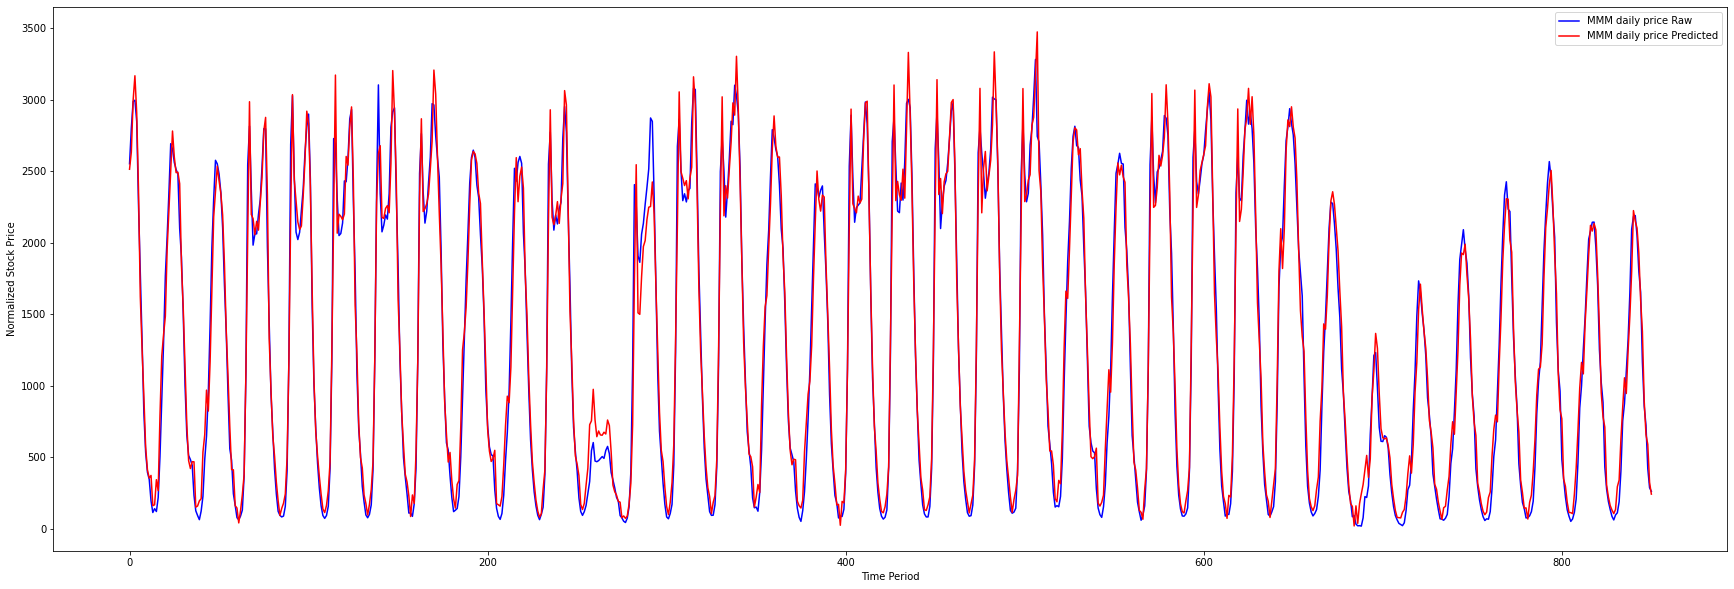

In [ ]:
# Plot predictions
plt.figure(figsize=(30,10))
plt.plot(y_test_unscale[851:1702, :, 0], color='blue', label="MMM daily price Raw")
plt.plot(y_pred_unscale[851:1702, :, 0], color='red', label="MMM daily price Predicted")
plt.xlabel("Time Period")
plt.ylabel("Normalized Stock Price")
plt.legend()
plt.show()